# Exercise 5
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-01-26: v.1.0. First public release. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')
from scipy.sparse import coo_matrix

## 3 - Constructing the matrix X (25 pts)

In [2]:
def construct_X(M, alphas, Np=None):
    '''
    Construct the matrix X of weights corresponding to the linear system of equations
    X*Beta = y, where Beta and y are vectors.
    
    Parameters
    ----------
    M: int
        One-sided length of the square tomogram. Full size of tomogram is D = M*M. 
    alphas: list
        List of measurement angles alpha, in degrees.
    Np: int
        Resolution of sensor array, optional.
    Returns:
    --------
    scipy.sparse.coo.coo_matrix 
        The constructed matrix X in sparse format .
    '''
    # Pixel spacing in tomography image and in sensor array.
    h = 1  
    
    # If no sensor resolution is given, set a large enough value to cover image.
    if Np == None:
        Np = np.ceil(np.sqrt(2)*M)
    
    D = int(M*M)               # Pixel count in tomography image.
    N = int(Np * len(alphas))  # Number of measured responses y_i.
    
    # Convert angles to radians.
    alphas_rad = np.radians(alphas) 
    
    # Construct unit vectors from the alphas.
    n = np.array([np.cos(alphas_rad), -np.sin(alphas_rad)]) # shape=(2,len(alphas))
    
    # Geometrical center of tomography image.
    geo_center = (M/2 - 0.5)*h           
    
    # Construct matrix with center coordinates for all pixels.
    linpos = h*np.arange(M) - geo_center             # 1D position vector.
    x_pos, y_pos = np.meshgrid(linpos, linpos)       # 2D meshgrid.
    C = np.array([x_pos.flatten(), y_pos.flatten()]) # Pixel centers, shape=(2,D).
    
    # Distance from first element in sensor to sensor origin.
    s0 = (Np/2 - 0.5)*h 
    
    # Find the pixel projections on the sensor.
    p = (n.T @ C) + s0 
    
    # Matrices of indices. 
    p_idx = np.indices(p.shape)
    
    # Find pixel index j from where ray originates. 
    j_low  = p_idx[1]
    j_high = p_idx[1]
    
    # Find sensor indices i where ray intersects sensor array. 
    i_low  = np.floor(p/h) + p_idx[0] * Np
    i_high = np.ceil(p/h)  + p_idx[0] * Np
    
    # Fractional coverage of ray from pixel j at sensor i.
    weights_high = p/h - np.floor(p/h)
    weights_low  = 1 - weights_high
    
    # Concatenate arrays.
    i_idx   = np.concatenate((i_low.flatten(), i_high.flatten()))
    j_idx   = np.concatenate((j_low.flatten(), j_high.flatten()))
    weights = np.concatenate((weights_low.flatten(), weights_high.flatten()))
    
    # Convert to integer datatype.
    i_idx = i_idx.astype(int)
    j_idx = j_idx.astype(int)
    
    # Form sparse matrix.
    X = coo_matrix((weights, (i_idx, j_idx)), shape=(N,D), dtype=np.float32)
    
    return X

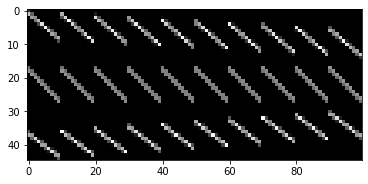

In [3]:
# Testing the constructor routine.
X = construct_X(10, [-33, 1, 42])
plt.imshow(X.todense())
plt.show()

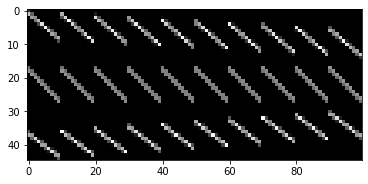

In [4]:
# Comparing with the included pre-computed example.
X_ex = np.load('hs_tomography/X_example.npy')
plt.imshow(X_ex)
plt.show()

## 4 - Recovering the image (6 pts)